## Use phot-griz environment (updated photutils)

In [1]:
# General imports
import os
import numpy as np
import matplotlib.pyplot as plt

# Segmentation
from astropy.io import fits
from photutils.segmentation import SourceFinder, make_2dgaussian_kernel, SourceCatalog
from photutils.background import Background2D, MedianBackground
from astropy.convolution import convolve

# grizli
from grizli.model import GrismFLT
import grizli

os.chdir("/Users/keith/astr/research_astr/summer-roman-project/new-sims/fits")

In [2]:
# Process direct image and produce segmentation map

# Open image
direct_file = "rotated_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits"
seg_file = "seg.fits"
direct_fits = fits.open(direct_file)
data, header = (direct_fits[1].data, direct_fits[1].header)


# Subtract background
bkg_estimator = MedianBackground()
bkg = Background2D(data, (511,511), filter_size=(3,3), bkg_estimator=bkg_estimator)
data -= bkg.background

# Convolve image
kernel = make_2dgaussian_kernel(3.0, 5)
convolved_data = convolve(data, kernel)

# Instantiate the SourceFinder and set threshold
finder = SourceFinder(npixels=7, nlevels=32, contrast=0.001)
threshold = 2 * bkg.background_rms

seg_map = finder(convolved_data, threshold)

# Save seg_map as fits
fits.writeto(seg_file, seg_map, header=header,overwrite=True)

Deblending:   0%|          | 0/6281 [00:00<?, ?it/s]

In [3]:
# Create Catalog
cat = SourceCatalog(data, seg_map, convolved_data=convolved_data)
cat.add_extra_property('id', np.cast[int](cat.label), overwrite=True)
cat.add_extra_property('x_flt', cat.xcentroid, overwrite=True)
cat.add_extra_property('y_flt', cat.ycentroid, overwrite=True)
mag = -2.5 * np.log10(cat.segment_flux)
cat.add_extra_property('mag', mag, overwrite=True)

columns = ['id', 'x_flt', 'y_flt', 'mag', 'area', 'semimajor_sigma', 'semiminor_sigma',
           'orientation', 'eccentricity', 'min_value', 'max_value']
tbl = cat.to_table(columns)

# seg_cat = "seg_cat.detect.cat"

# if os.path.exists(seg_cat):
#             os.remove(seg_cat)
# tbl.write(seg_cat, format='ascii.commented_header')

In [4]:
tbl[np.where(tbl['y_flt'] <= 10)].pprint(max_width=1000)

 id       x_flt              y_flt                mag           area  semimajor_sigma    semiminor_sigma       orientation          eccentricity          min_value            max_value     
                                                                pix2        pix                pix                 deg                                                                       
--- ------------------ ------------------ -------------------- ----- ------------------ ------------------ -------------------- ------------------- --------------------- -------------------
  1  547.1275849948366 2.4271251831426457  -2.5230022221505544  35.0 1.5869476192007406 1.2100715388994576   13.061058238477331  0.6469704062475063  -0.06489644628572569  1.2772824964404244
  2 1240.3754083308054 1.8647066747509773  -1.4679434632178598  17.0 1.1868316197393327  0.946689606554779    76.24156234660595  0.6031057224785653   0.06382979452610016  0.6524822562932968
  3 1807.6482047276445 2.8970999174705425  -2.3919

In [5]:
tbl[np.where(tbl['id'] <= 22)].pprint(max_width=1000)

 id       x_flt              y_flt                mag           area  semimajor_sigma    semiminor_sigma       orientation          eccentricity          min_value            max_value     
                                                                pix2        pix                pix                 deg                                                                       
--- ------------------ ------------------ -------------------- ----- ------------------ ------------------ -------------------- ------------------- --------------------- -------------------
  1  547.1275849948366 2.4271251831426457  -2.5230022221505544  35.0 1.5869476192007406 1.2100715388994576   13.061058238477331  0.6469704062475063  -0.06489644628572569  1.2772824964404244
  2 1240.3754083308054 1.8647066747509773  -1.4679434632178598  17.0 1.1868316197393327  0.946689606554779    76.24156234660595  0.6031057224785653   0.06382979452610016  0.6524822562932968
  3 1807.6482047276445 2.8970999174705425  -2.3919

In [6]:
# Instantiate the GrismFLT object
sim_fov0 = GrismFLT(direct_file=direct_file, seg_file=seg_file, pad=100)



Image cutout: x=slice(0, 4088, None), y=slice(0, 4088, None) [Out of range]
rotated_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits / Pad ref HDU with 264 pixels
rotated_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits / blot segmentation seg.fits[0]
The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       config_testbed      imagefindpars           mapreg       
       photeq            pixreplace           pixtopix            pixtosky      
  refimagefindpars       resetbits          runastrodriz          skytopix      
     tweakback            tweakreg           updatenpol
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...


In [7]:
sim_fov0.compute_full_model(mag_limit=28, size=75, compute_size=False)

Text(0.5, 1.0, 'Direct Image -> Simulated Grism Image')

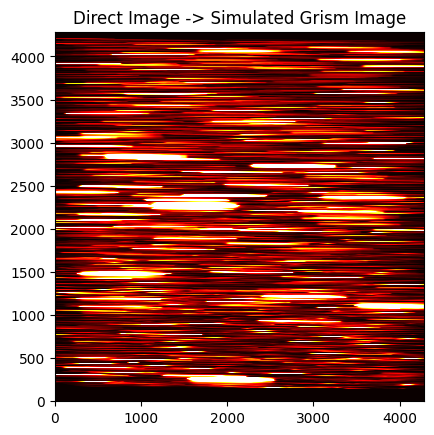

In [8]:
fig, ax = plt.subplots()
ax.imshow(sim_fov0.model/1.9e18, interpolation='Nearest', 
           origin='lower', vmin=-0.01, vmax=10, cmap='hot')
ax.set_title("Direct Image -> Simulated Grism Image")


In [9]:
raise Exception("Pause before saving")

In [10]:
fits.writeto("full_sim.fits", sim_fov0.model, header=header, overwrite=True)